- Data Cleaning
Remove punctuation, special characters, and digits
Convert all text to lowercase
- Tokenization
Split messages into individual words (tokens)
- Stopword Removal
Remove common non-informative words (e.g., "the", "and")
- Stemming / Lemmatization
Reduce words to their root form (e.g., "running" → "run")
- Vectorization
First, try Bag-of-Words and TF-IDF for exploratory analysis

- For topic modeling, you'll need:
Document-term matrix as input to LDA
Save topic proportions θ<sub>d</sub> for each message

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import torch

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

in_dir = '/Users/matteopiccagnoni/Desktop/DTU/Model-Based Machine Learning/project/'
df_dir = 'sms+spam+collection/SMSSpamCollection'
df_sms = pd.read_csv(in_dir + df_dir, sep='\t', header=None, names=['label', 'message'])
df_sms.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteopiccagnoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df = df_sms.copy()
#print(df.head())

used stemming word chopping becuase it's cool and it works fine in ML, the only thing is that it groups every for examplem crazy, craziness, exc, into crazi. it is fine but is not human readable. 

In [4]:
# Text Cleaning Function
def clean_message(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)       # Remove URLs
    text = re.sub(r'\d+', '', text)                   # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens 

df['tokens'] = df['message'].apply(clean_message)
print(df[['message', 'tokens']].head())

                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                              tokens  
0  [go, jurong, point, crazi, avail, bugi, n, gre...  
1                       [ok, lar, joke, wif, u, oni]  
2  [free, entri, wkli, comp, win, fa, cup, final,...  
3      [u, dun, say, earli, hor, u, c, alreadi, say]  
4  [nah, dont, think, goe, usf, live, around, tho...  


In [5]:
# Join tokens back to strings (needed for CountVectorizer)
texts_str = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Create bag-of-words matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts_str)

# Convert to torch tensor
X_tensor = torch.tensor(X.toarray(), dtype=torch.float)

# Optional: check shape
print("Input for Pyro LDA:", X_tensor.shape)  # should be (num_docs, vocab_size)


Input for Pyro LDA: torch.Size([5572, 7099])


In [9]:
# Print first cleaned message as tokens
print("\nSample tokens:", df['tokens'].iloc[0])

# Print the BoW vector for the first message (as vector index → count)
print("Sample BoW row:", X_tensor[0].nonzero(as_tuple=True)[0].tolist())
print("Word counts:", X_tensor[0][X_tensor[0] > 0 ].tolist())

# Print the actual words from the vectorizer
vocab = vectorizer.get_feature_names_out()
print("Words in BoW row:", [vocab[i] for i in X_tensor[0].nonzero(as_tuple=True)[0]])



Sample tokens: ['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']
Sample BoW row: [212, 404, 790, 792, 1063, 1280, 2363, 2416, 2453, 3126, 3265, 4621, 6689, 6899]
Word counts: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Words in BoW row: ['amor', 'avail', 'buffet', 'bugi', 'cine', 'crazi', 'go', 'got', 'great', 'jurong', 'la', 'point', 'wat', 'world']


thought to modify the slang and grammatical errors into correct words but the thing is that also those can bring information if we are detecting spam or not

# visualizations for later

label
ham     4825
spam     747
Name: count, dtype: int64


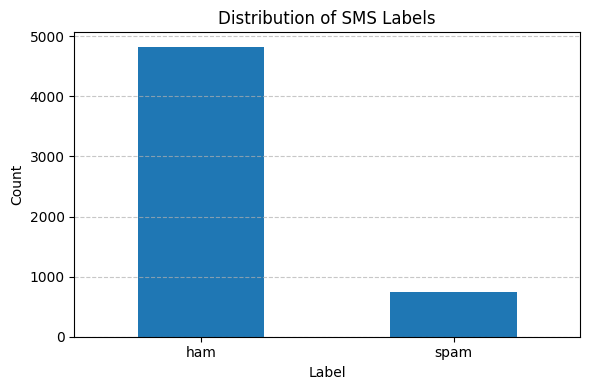

In [10]:
#df_sms.head()
print(df_sms['label'].value_counts())

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of SMS Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

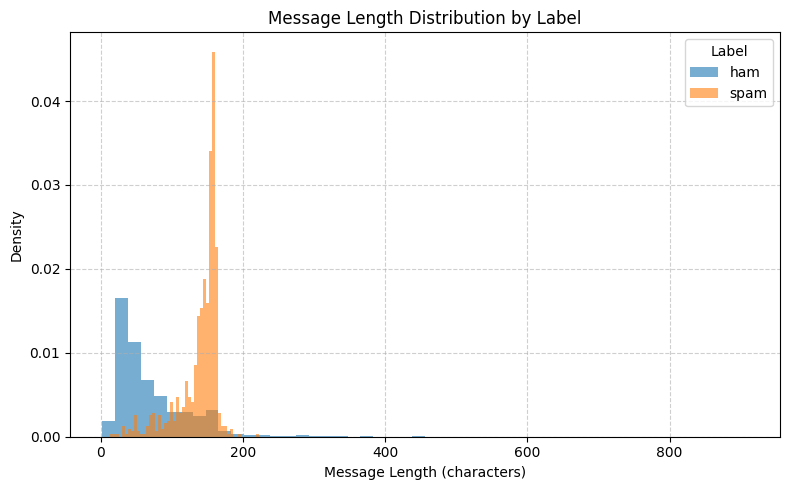

message length statistics:
count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message_length, dtype: float64


In [11]:
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(8, 5))
for label in df['label'].unique():
    subset = df[df['label'] == label]
    plt.hist(subset['message_length'], bins=50, alpha=0.6, label=label, density=True)

plt.title('Message Length Distribution by Label')
plt.xlabel('Message Length (characters)')
plt.ylabel('Density')
plt.legend(title='Label')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print('message length statistics:')
print(df['message_length'].describe()) # get the statistics of the message length


df = df.drop('message_length', axis=1) # drop the message_length column


In [12]:
df_spam = df[df['label'] == 'spam'].copy()
df_ham = df[df['label'] == 'ham'].copy()

df_spam['message_length'] = df_spam['message'].apply(len)
df_ham['message_length'] = df_ham['message'].apply(len)

print('spam message length statistics:')
print(df_spam['message_length'].describe()) 
print('ham message length statistics:')
print(df_ham['message_length'].describe()) 


spam message length statistics:
count    747.000000
mean     138.670683
std       28.873603
min       13.000000
25%      133.000000
50%      149.000000
75%      157.000000
max      223.000000
Name: message_length, dtype: float64
ham message length statistics:
count    4825.000000
mean       71.482487
std        58.440652
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: message_length, dtype: float64


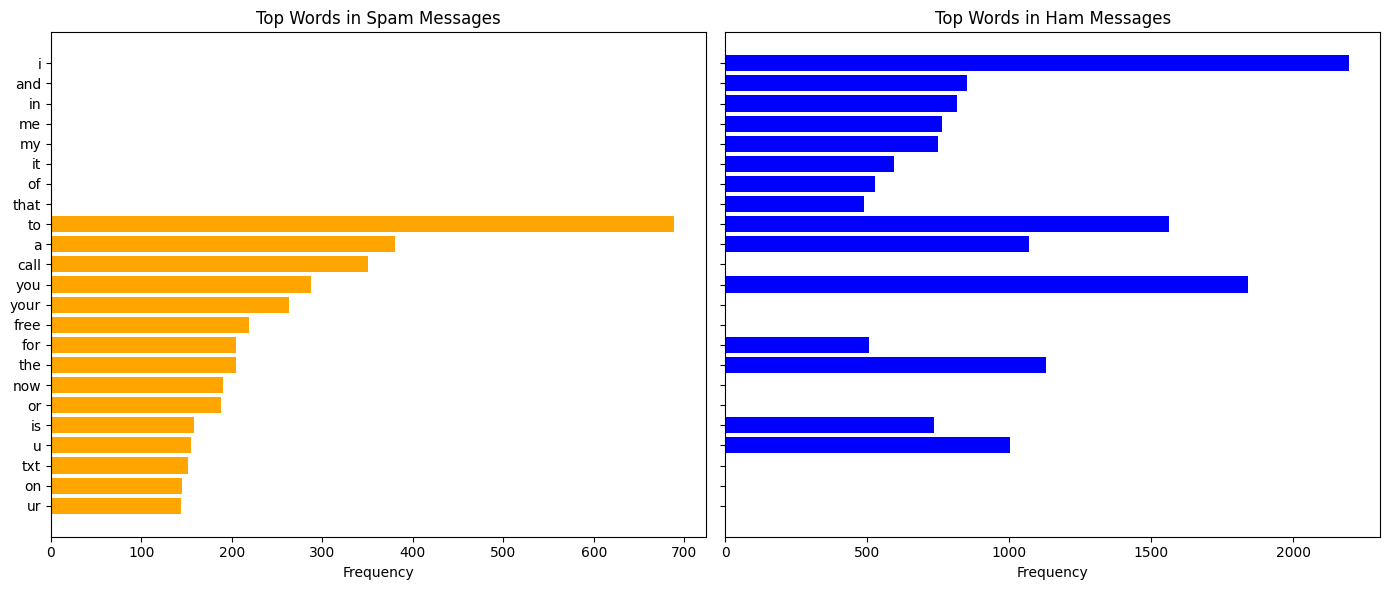

In [13]:
from collections import Counter
import re

def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    return text.split()

spam_words = df_spam['message'].apply(tokenize).sum()
ham_words = df_ham['message'].apply(tokenize).sum()

spam_counter = Counter(spam_words)
ham_counter = Counter(ham_words)

top_spam = spam_counter.most_common(15)
top_ham = ham_counter.most_common(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Spam
words, counts = zip(*top_spam)
axes[0].barh(words[::-1], counts[::-1], color='orange')
axes[0].set_title("Top Words in Spam Messages")
axes[0].set_xlabel("Frequency")

# Ham
words, counts = zip(*top_ham)
axes[1].barh(words[::-1], counts[::-1], color='blue')
axes[1].set_title("Top Words in Ham Messages")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()